In [139]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
from skimage import transform
#import torch
#import torch.nn as nn
#from torch.utils.data import Dataset, DataLoader
#import torch.multiprocessing as mp
#import monai
import sys
import argparse
import random
from datetime import datetime
import shutil
import glob
import pandas as pd
import nibabel as nib
import pickle
import time
from PIL import Image
import seaborn as sns
import scipy


# sys.path.append('../../../modified_medsam_repo')
# from MedSAM_HCP.dataset import MRIDataset, load_datasets
# from MedSAM_HCP.MedSAM import MedSAM
# from MedSAM_HCP.build_sam import build_sam_vit_b_multiclass
# from MedSAM_HCP.utils_hcp import *
# from MedSAM_HCP.loss_funcs_hcp import *

In [69]:
import seaborn_image

ModuleNotFoundError: No module named 'seaborn_image'

In [3]:
hcp_id = '100206'
hcp_dir = f'/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pretrained_image_encoded_slices/{hcp_id}/*.npy'

brats_id = '001'
brats_dir = f'/gpfs/data/luilab/karthik/MICCAI_BraTS2020_TrainingData/encoded_slices/{brats_id}/*.npy'

In [112]:
hcp_slice_num = 100
hcp_img_p = f'/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/dir_structure_for_yolov7/train/images/{hcp_id}_slice{hcp_slice_num}.png'
hcp_emb_p = f'/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pretrained_image_encoded_slices/{hcp_id}/{hcp_slice_num}.npy'

brats_slice_num = 90
brats_img_p = f'/gpfs/data/luilab/karthik/MICCAI_BraTS2020_TrainingData/images/images{brats_id}_slice{brats_slice_num}.png'
brats_emb_p = f'/gpfs/data/luilab/karthik/MICCAI_BraTS2020_TrainingData/encoded_slices/{brats_id}/{brats_slice_num}.npy'

In [113]:
hcp_img = Image.open(hcp_img_p)
brats_img = Image.open(brats_img_p)

hcp_img_np = np.array(hcp_img)
brats_img_np = np.array(brats_img)

hcp_emb = np.load(hcp_emb_p)
brats_emb = np.load(brats_emb_p)

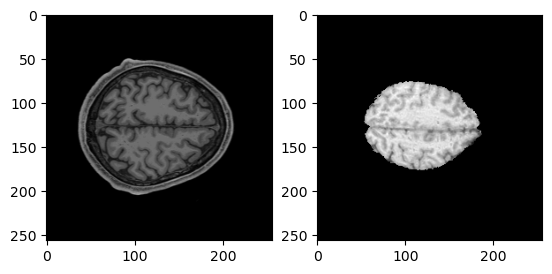

In [114]:
fig, axs = plt.subplots(1,2, squeeze=False)
axs[0,0].imshow(hcp_img)
axs[0,1].imshow(brats_img)

In [180]:
raw_path = '/gpfs/data/cbi/hcp/hcp_seg/data_orig/100206/mri/brainmask.mgz'
raw_nifti = nib.load(raw_path)
dat = raw_nifti.get_fdata()

# now back to NIFTI
raw_nifti = nib.Nifti1Image(dat.astype(float), affine=raw_nifti.affine)
nib.save(raw_nifti, f'/gpfs/home/kn2347/to_del/hcp_t1_skullstripped.nii')

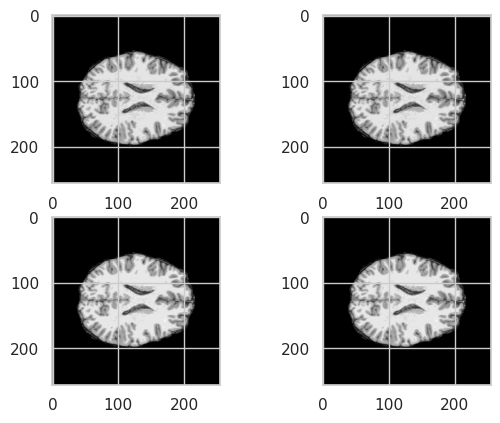

In [176]:
paths = ['/gpfs/data/cbi/hcp/hcp_seg/data_orig/100206/mri/brain.mgz',
    '/gpfs/data/cbi/hcp/hcp_seg/data_orig/100206/mri/brain.finalsurfs.mgz',
    '/gpfs/data/cbi/hcp/hcp_seg/data_orig/100206/mri/brainmask.mgz',
    '/gpfs/data/cbi/hcp/hcp_seg/data_orig/100206/mri/brainmask.auto.mgz']

fig, axs = plt.subplots(2,2)
for i in range(4):
    r = i // 2
    c = i % 2
    axs[r,c].imshow(easy_to_plot(nib.load(paths[i]).get_fdata()[:,128,:]))

#plt.imshow(easy_to_plot(nib.load('/gpfs/data/cbi/hcp/hcp_seg/data_orig/100206/mri/brain.finalsurfs.mgz').get_fdata()[:,128,:]))
#plt.axis('off')

In [116]:
# apply min max normalization, as is done before the embedding is calculated
def min_max_norm(x):
    return (x - x.min()) / np.clip(
        x.max() - x.min(), a_min=1e-8, a_max=None
    )

hcp_img_np = min_max_norm(hcp_img_np)
brats_img_np = min_max_norm(brats_img_np)

                   0
count  196608.000000
mean        0.128897
std         0.214205
min         0.000000
25%         0.000000
50%         0.000000
75%         0.229508
max         1.000000
                   0
count  196608.000000
mean        0.113576
std         0.273902
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


(-0.5, 255.5, 255.5, -0.5)

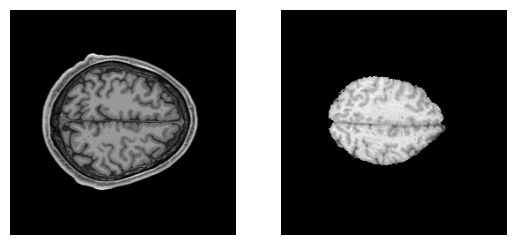

In [118]:
print(pd.DataFrame(hcp_img_np.flatten()).describe())
print(pd.DataFrame(brats_img_np.flatten()).describe())

fig, axs = plt.subplots(1,2, squeeze=False)
axs[0,0].imshow(hcp_img_np)
axs[0,1].imshow(brats_img_np)
axs[0,0].axis('off')
axs[0,1].axis('off')

### Embedding comparison

In [126]:
brats_emb.shape

(256, 64, 64)

[Text(0.5, 0, 'Embedding value')]

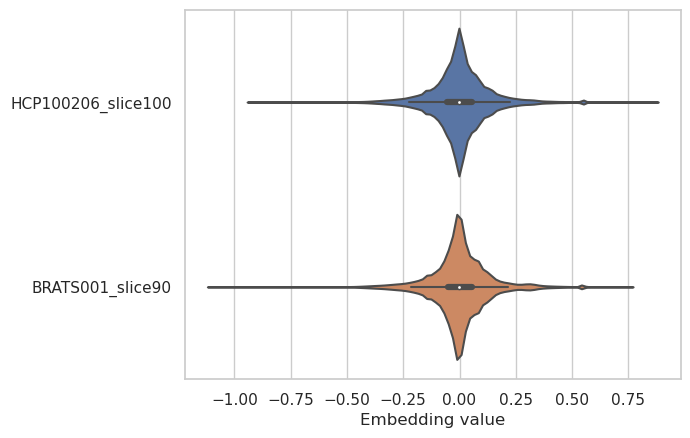

In [138]:
#print(pd.DataFrame(hcp_emb.flatten()).describe())
#print(pd.DataFrame(brats_emb.flatten()).describe())
df = pd.DataFrame({'HCP100206_slice100': hcp_emb.flatten(), 'BRATS001_slice90': brats_emb.flatten()})
sns.set(style='whitegrid')
ax = sns.violinplot(data=df, orient='h')
ax.set(xlabel='Embedding value')

In [64]:
def easy_to_plot(arr):
    assert len(arr.shape) == 2
    res = np.repeat(arr[:,:,None], 3, axis = 2)
    res = (res - res.min()) / (res.max() - res.min())
    return res

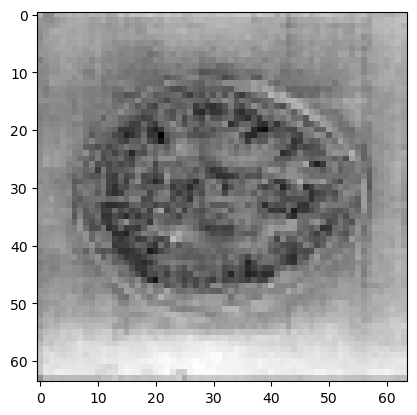

In [65]:
plt.imshow(easy_to_plot(hcp_emb[0,:,:]))

(256, 64, 64)
(256, 64, 64)


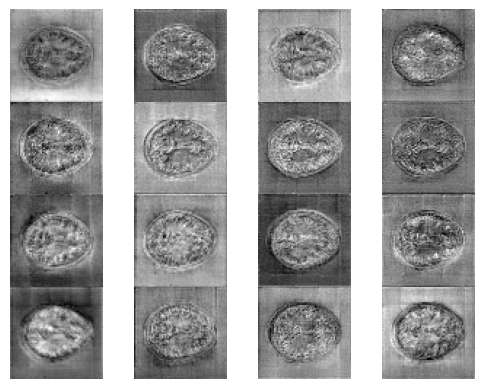

In [71]:
# do all HCP filters
print(hcp_emb.shape)
print(brats_emb.shape)

n = 4
fig, axs = plt.subplots(n,n)
for i in range(n*n):
    r = i // n
    c = i % n
    axs[r,c].imshow(easy_to_plot(hcp_emb[i, :, :]))
    #axs[r,1].imshow(easy_to_plot(brats_emb[i, :, :]))
    axs[r,c].axis('off')
    #axs[i,1].axis('off')

fig.subplots_adjust(wspace=0, hspace=0)
#fig.tight_layout()
fig.show()


# the (64,64) represents the upsampled image (1024,1024) subdivided into patches of size 16x16 (resulting in 64 patches by 64 patches)
# the 256 is the vector for each patch

In [ ]:
n = 4
fig, axs = plt.subplots(n,n)
for i in range(n*n):
    r = i // n
    c = i % n
    axs[r,c].imshow(easy_to_plot(brats_emb[i, :, :]))
    #axs[r,1].imshow(easy_to_plot(brats_emb[i, :, :]))
    axs[r,c].axis('off')
    #axs[i,1].axis('off')

fig.subplots_adjust(wspace=0, hspace=0)
#fig.tight_layout()
fig.show()


# the (64,64) represents the upsampled image (1024,1024) subdivided into patches of size 16x16 (resulting in 64 patches by 64 patches)
# the 256 is the vector for each patch

In [ ]:
n = 15
fig, axs = plt.subplots(n,2, figsize=(5, 40))
for i in range(n):
    axs[i,0].imshow(easy_to_plot(hcp_emb[i, :, :]))
    axs[i,1].imshow(easy_to_plot(brats_emb[i, :, :]))
    axs[i,0].axis('off')
    axs[i,1].axis('off')

fig.subplots_adjust(wspace=0.01, hspace=0)
#fig.tight_layout()
#fig.show()
fig.savefig('/gpfs/home/kn2347/figs/comparing_hcp_brats_first_15_filters.png', dpi=300)


# the (64,64) represents the upsampled image (1024,1024) subdivided into patches of size 16x16 (resulting in 64 patches by 64 patches)
# the 256 is the vector for each patch